# SLT-CE-4: Model Validation

## References 

[1] [Information Theoretic Model Selection for Pattern Analysis](https://proceedings.mlr.press/v27/buhmann12a/buhmann12a.pdf)

[2] [Approximate Sorting (original paper)](https://link.springer.com/book/10.1007/978-3-642-40602-7)

[3] [Tutorial on Approximate Sorting](https://ml2.inf.ethz.ch/courses/slt/tutorials/Tutorial-approximate-sorting.pdf)


## Introduction

<p style="background-color:#adebad;">
We return to the problem of k-means clustering, but this time the goal is to find the optimal number of clusters. Having read the reference paper [1], we will try to reproduce the experiments detailed in their section 4.1. However, instead of a Gaussian Mixture Model, we are going to use modified setups, see below. Use Deterministic Annealing to perform clustering. You can reuse your DA algorithms from coding exercise 2 (slt-ce-2).
</p>

In [401]:
import numpy as np
import matplotlib.pylab as plt
import time

import sklearn as skl
from functools import reduce

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Explain the main idea behind the Model Validation. Write down the equations you are going to use for solving the problems and shortly explain the variables that are involved (check section 4.1 in [1]):   
</p>

The idea is to view the model in a information theoretic perspective. To an algortihm $\mathcal A$ we associate a communication channel $C_{\mathcal A}$ and measure the models effectiveness (a balance between complexity and robustness) in terms of the channels (information theoretical) capacity. Given datasets $X^{(q)} = \{x_i^{(q)}:i\leq n\}, q\in \{1,2\}, n\in \mathbb{N}$ we have the following bound for achievable rates $\rho$ with asymptotically vanishing error rates:
$$
\rho \leq \mathcal {I}_T = \frac{1}{n} \log |\{\tau_s\}| + \frac{1}{n}\sum_{i=1}^n \left( \log \sum_{k=1}^K e^{-(\epsilon^{(1)}_{i,k}+\epsilon^{(2)}_{i,k})/T} - \log \sum_{k=1}^K e^{-\epsilon^{(1)}_{i,k}/T} \sum_{k=1}^Ke^{-\epsilon^{(2)}_{i,k}/T} \right)
$$
where $|\{\tau_s\}|$ is the number of distinct clusterings on the datasets (i.e. $K^n$) and $\epsilon_{i,k}^{(q)} = ||x_i^{(q)} - y_k^{(q)}||$, where $\{y_k^{(q)}:k\leq K\}$ are the clusters generated when applying $\mathcal A$ to dataset $q \in \{1, 2\}$, for $K\in \mathbb N$. Hence, we use $\mathcal {I}_T$ as a basis for model validation, choosing the hyperparameter $T$ that maximizes this mutual information.


For this excercise we shall use the following data source:

$$p(\textbf{x})=\frac{1}{2}\mathcal{N}(\textbf{x} | \textbf{0}, \sigma_1^2\mathbb{I}) + 
\frac{1}{2}\mathcal{N}(\textbf{x} | r\textbf{v},\sigma_2^2\mathbb{I}) $$

with $\mathbf{x}, \mathbf{v} \in \mathbb{R}^d$, $\lVert \mathbf{v} \rVert=1$ and $r\in\mathbb{R}_+$.
Implement a function generating data from this distribution:


In [402]:
def generate_data(var_1, var_2, r, v, num_samples):
    """Generate data from the described model using provided parameters:
    Args:
            var_1 (number): varience of the first cluster
            var_2 (number): varience of the second cluster
            r (number): distance r to the center of the second cluster
            v (np.ndarray): direction v of the center of the second cluster
            num_samples (number): number of points to be generated
    
    Returns:
            data (np.ndarray): generated points
            labels (np.ndarray): true cluster assigment for the generated points 
    """
    
    d = v.size
    I = np.identity(d)
    N = np.random.RandomState(42).binomial(n=num_samples, p=0.5)
    data = np.concatenate((np.random.multivariate_normal(mean=np.zeros(d), cov=var_1*I, size=N), np.random.multivariate_normal(mean=r*v, cov=var_2*I, size=num_samples-N)))
    labels = np.concatenate((np.zeros(N), np.ones(num_samples-N)))
    
    return data, labels

<p style="background-color:#adebad;">
Generate and plot 2D points for different combinations of $\sigma_1$, $\sigma_2$ and $r$. Color the generated points according to their cluster assigment.
</p>

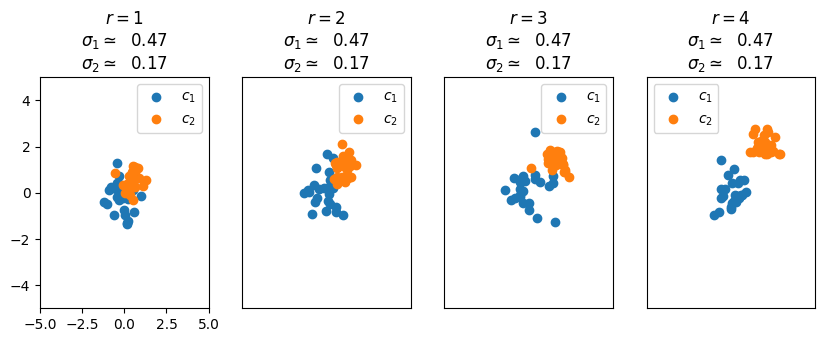

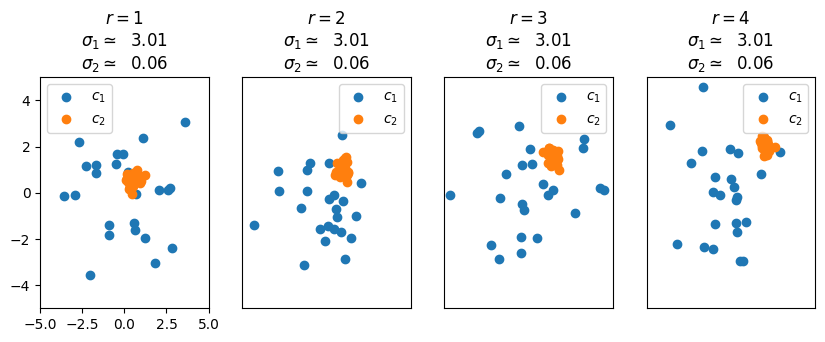

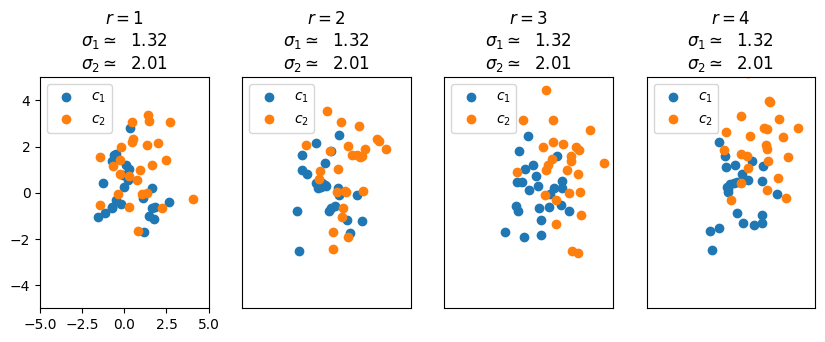

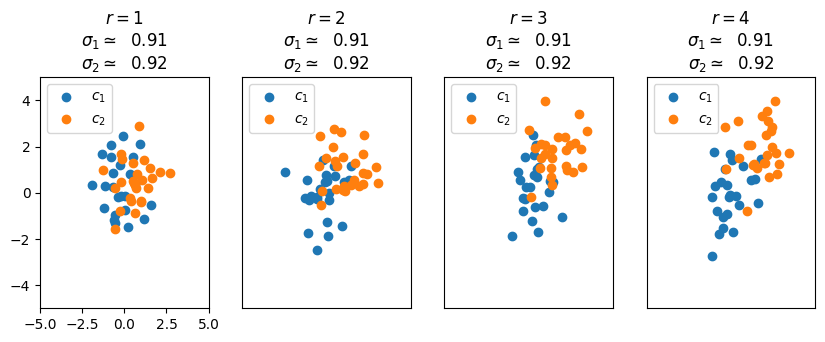

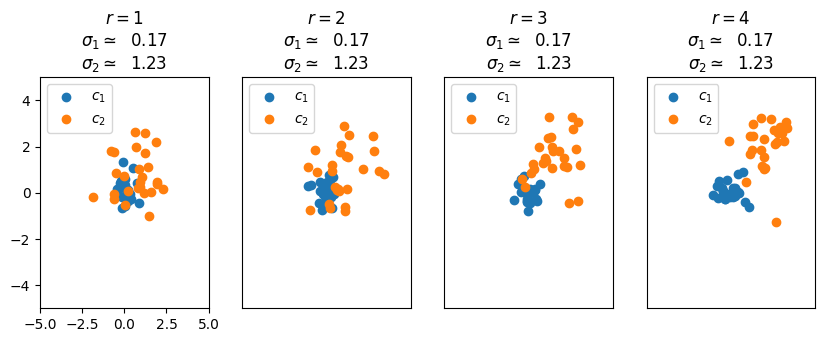

In [506]:
num = 5
var_1 = np.random.exponential(scale=1, size=num)
var_2 = np.random.exponential(scale=1, size=num)
rs   = np.arange(1, 5)
for i in range(num):
    plt.figure(figsize=(10,3))
    for r in rs:
        plt.subplot(1, 4, r)
        if r != 1: 
            plt.xticks([], [])
            plt.yticks([], [])
        data, labels = generate_data(var_1[i], var_2[i], r, v=np.array([0.5, 0.5]), num_samples =50)
    
        plt.scatter(data[:,0][labels==0], data[:,1][labels==0], label='$c_1$')
        plt.scatter(data[:,0][labels==1], data[:,1][labels==1], label='$c_2$')
        #plt.scatter([r*0.5], [r*0.5], c='k')
        #plt.scatter([0], [0], c='k')


        plt.legend()
        plt.title('$r={}$\n$\sigma_1\simeq${:6.2f}\n$\sigma_2\simeq${:6.2f}'.format(r, var_1[i], var_2[i]))
        plt.ylim(-5, 5)
        plt.xlim(-5, 5)
    plt.show()


<p style="background-color:#adebad;">
In order to reproduce the results described in the reference paper [1], section 4.1, we need to calculate the mutual information of two clusterings. Provide an implementation of the correspondent function according to its docstring. You may want to check section 3 in [1] for more details.
</p>

In [510]:
def mutual_information(X_1, X_2, y_1, y_2, t):
    """Compute mutual information of two clusterings
    Args:
        X_1 (np.ndarray): first dataset
        X_2 (np.ndarray): second dataset
        y_1 (np.ndarray): cluster centers for the first dataset
        y_2 (np.ndarray): cluster centers for the second dataset
        t (float): temperature T
    Returns:
        mutual_information (float): mutual information of X_1 and X_2
    """
    
    K = y_1.shape[0]
    
    eps_1 = np.linalg.norm(X_1[:,np.newaxis,:]-y_1, axis=2)**2
    eps_2 = np.linalg.norm(X_2[:,np.newaxis,:]-y_2, axis=2)**2
    
    # use "log-sum-exp trick" for numerical stability
    def log_sum_exp(x):
        c = np.max(x, axis=1, keepdims=True)
        return np.log(np.sum(np.exp(x - c), axis=1, keepdims=True)) + c
    
    mutual_information = np.log(K) + np.mean(log_sum_exp(-(eps_1+eps_2)/t) - log_sum_exp(-eps_1/t) - log_sum_exp(-eps_2/t))

    return mutual_information


In [405]:
data, labels = generate_data(var_1=0.5, var_2=0.5, r=1,  v=np.array([1, 0]), num_samples=10000)
centers = np.array([[0, 0], [1,0]])
print(mutual_information(data, data, centers, centers, 1))

0.2827838333520782


<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Now fix the parameters $\sigma_1=\sigma_2=\sigma$ and produce a plot of the mutual information (MI) vs. temperature for different $r$ (Similar to the Figure 2b in [1]; put all curves in one figure). Modify your Deterministic Annealing class such that it logs MI score for every evaluated temperature T. Note that mutual information score is defined for a hard assignment while deterministic annealing algorithm result to a probabilistic one.
</p>

In [406]:
from scipy.optimize import linear_sum_assignment
class DeterministicAnnealing(skl.base.BaseEstimator, skl.base.TransformerMixin):
    
    def __init__(self, n_clusters=4, T_max=20, T0=0.01, tau=1e-4, eps=1e-4, xi=0.9):
        self.n_clusters = n_clusters
        self.T = T_max
        self.T0 = T0
        self.tau = tau
        self.eps = eps
        self.xi = xi
        self.MIs = np.array([])
        self.Ts = np.array([])
        self.effective_clusters = list()
        # Add more parameters, if necessary.

    def perturb(self, centroids):
        dists = np.linalg.norm(centroids[:,np.newaxis,:]-centroids, axis=2, ord=2) + np.identity(self.n_clusters)
        idx = np.where(dists < self.eps)[0]
        centroids[idx, :] += np.random.normal(scale=1e-4, size=(len(idx), centroids.shape[1]))
        return centroids
        
    def EM(self, centroids, X):
        error = 1
        while error > self.tau:
            old_centroids = centroids.copy()
            
            # Estimate
            P = np.exp(-np.linalg.norm(X[:,np.newaxis,:]-old_centroids, axis=2)**2/self.T)
            P /= np.sum(P, axis=1)[:, np.newaxis]
            
            # Maximize
            centroids = np.matmul(P.T, X) / np.reshape(np.sum(P, axis=0), (-1, 1))
    
            error = np.linalg.norm(centroids - old_centroids)  
        return centroids
    
    def fit(self, X_1, X_2):
        
        np.random.seed(42)
            
        # Initialize
        self.centroids_1 = np.tile(np.mean(X_1, axis=0), (self.n_clusters, 1))
        self.centroids_2 = np.tile(np.mean(X_2, axis=0), (self.n_clusters, 1))

        while self.T > self.T0:

            # Add random pertubation
            self.centroids_1 = self.perturb(self.centroids_1)
            self.centroids_2 = self.perturb(self.centroids_2)

            # Estimate p and Maximize entropy w.r.t. y
            self.centroids_1 = self.EM(self.centroids_1, X_1)
            self.centroids_2 = self.EM(self.centroids_2, X_2)
            
            # Match clusters using Hungarian algorithm
            _, perm = linear_sum_assignment(np.linalg.norm(self.centroids_1[:,np.newaxis,:]-self.centroids_2, axis=2))
            
            # Calculate mutual information
            MI = mutual_information(X_1, X_2, self.centroids_1, self.centroids_2[perm], self.T)
            
            # Log current data
            self.MIs = np.append(self.MIs, MI)
            self.Ts = np.append(self.Ts, self.T)
            self.effective_clusters.append(np.unique(np.round(self.centroids_1, decimals=2), axis=0).shape[0])
            self.T *= self.xi  
        
        return self

In [407]:
#self.centroid_dist.append(np.reshape(np.linalg.norm(self.centroids_1[:, np.newaxis, :] - np.mean(X_1, axis=0), axis=2), (self.n_clusters, )))
#self.effective_clusters.append(np.unique(np.round(self.centroids_1, decimals=2), axis=0).shape[0])

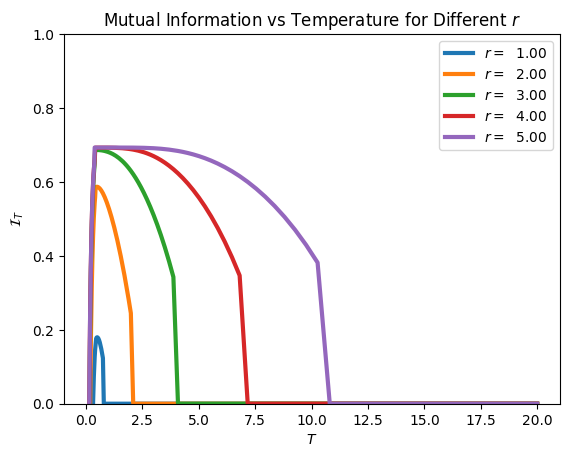

In [409]:
var_1, var_2 = 0.25, 0.25
v = np.array([0,1])

#np.arange(1, 6)
for r in np.arange(1, 6):
    
    data_1, _ = generate_data(var_1, var_2, r, v, num_samples=10000)
    data_2, _ = generate_data(var_1, var_2, r, v, num_samples=10000)

    DA = DeterministicAnnealing(xi=0.95).fit(data_1, data_2)
    plt.plot(DA.Ts, DA.MIs, linewidth=3, label='$r =${:6.2f}'.format(r))
    #plt.plot(DA.Ts, DA.effective_clusters)
    plt.ylim(0,1)
    
plt.title('Mutual Information vs Temperature for Different $r$')
plt.ylabel('$\mathcal{I}_T$')
plt.xlabel('$T$')
plt.legend()
plt.show()



<p style="background-color:#adebad;">
Additionally, plot the maximum MI vs. the distance $r$. What do you observe?
</p>

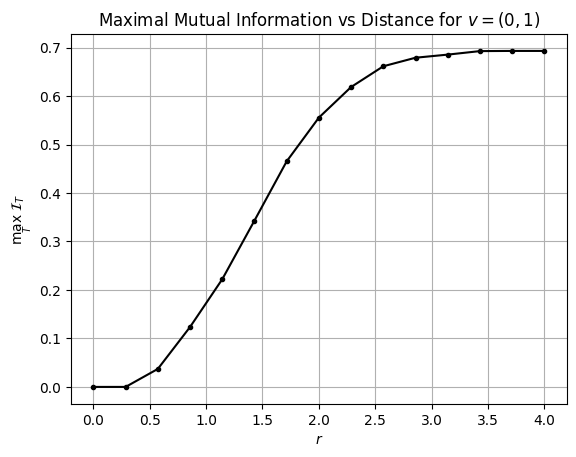

In [512]:
var_1, var_2, v = 0.25, 0.25,  np.array([0,1])

def max_MI_wrt_r(rs, v=np.array([0,1]), num_samples=1000, xi=0.9):
    MI_array = list()
    for r in rs: 
        data_1, _ = generate_data(var_1, var_2, r, v, num_samples=num_samples)
        data_2, _ = generate_data(var_1, var_2, r, v, num_samples=num_samples)
        DA = DeterministicAnnealing(xi=xi).fit(data_1, data_2)

        MI_array.append(DA.MIs)
    return rs, np.array(np.max(MI_array, axis=1))

rs, max_MI = max_MI_wrt_r(np.linspace(1e-3, 4, 15), xi=0.95)
plt.plot(rs, max_MI, marker='.', c='k')
plt.title('Maximal Mutual Information vs Distance for $v = (0,1)$')
plt.xlabel('$r$')
plt.ylabel('$\max_{T} \ \mathcal{I}_T$')
plt.grid(True)
plt.show()

The maximum MI increases quite rapidly for $r \in [1, 2]$, but plateaus at zero for lower values and at around 0.7 for higher values. This indicates that there is a breakpoint for $r \in [0,1]$ where the model starts to easily distinguish the clusters.

<p style="background-color:#adebad;">
Investigate the behavior of the maximal MI as a function of the number of data samples $n$ and the data dimension $d$, i.e. plot several curves MI vs. $r$ for different $n$ and $d$. Try to organize the curves into figures, such that one can observe the behavior clearly.
</p>

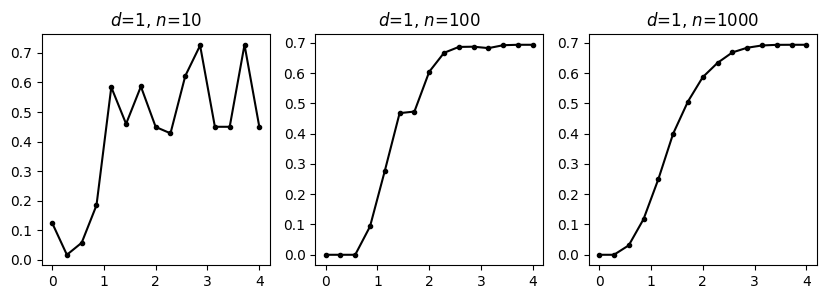

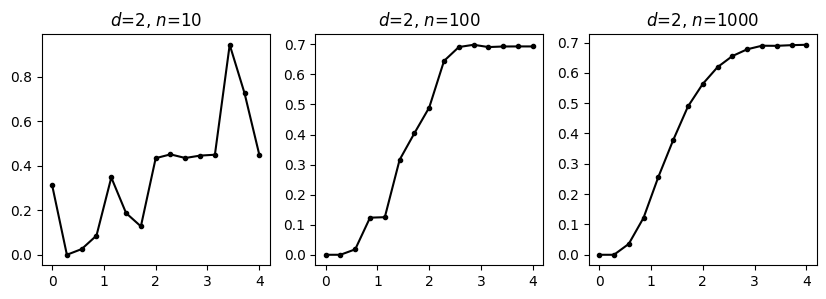

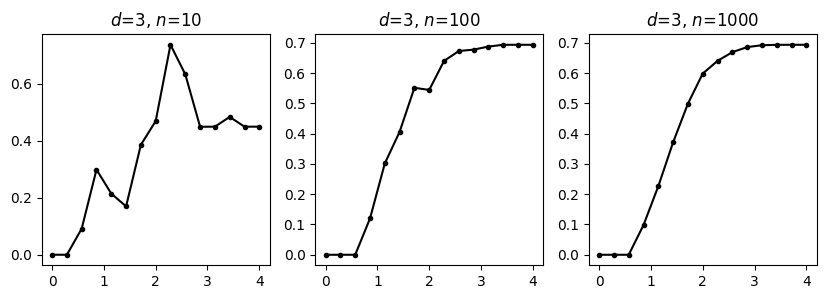

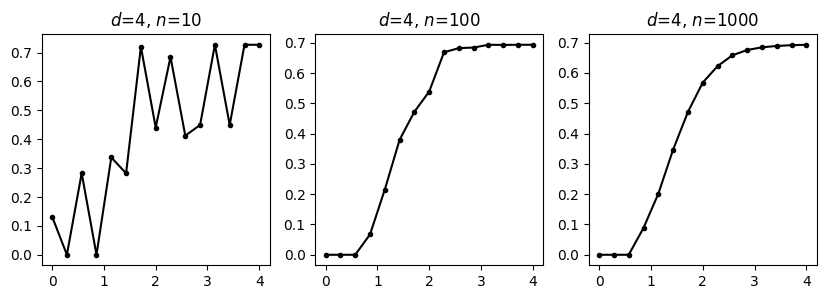

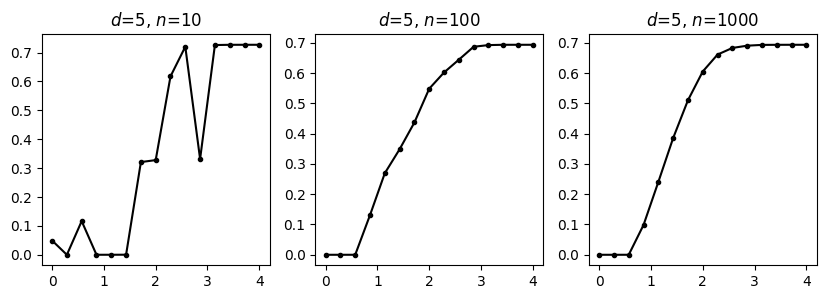

In [ ]:
var_1, var_2 = 0.25, 0.25
ds = np.arange(1, 6)
vs = [np.append(np.zeros(d-1), 1) for d in ds]
ns = [10**l for l in np.arange(1, 4)]

for v in vs:
    plt.figure(figsize=(10,3))
    for i, n in enumerate(ns):
        plt.subplot(1, len(ns), i+1)
        rs, max_MI = max_MI_wrt_r(rs=np.linspace(1e-3, 4, 15), v=v, num_samples=n)
        plt.plot(rs, max_MI, marker='.', c='k')
        plt.title(f'$d$={v.shape[0]}, $n$={n}')
    plt.show()

<p style="background-color:#adebad;">
Any implementation/computational/numerical issues?
</p>

In high dimensions, the Hungarian algorithm becomes numerically unstable.

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

Use $r$ such that one can not quite distinguish the two clusters (i.e. the maximum MI is not clearly realized with two clusters, i.e. k=2). The two clusters are overlapping so much that they appear as one cluster. Now reduce the variance $\sigma_2$ of the second cluster so that it creates a concentrated peak within the first cluster. Again, plot MI vs. $T$ for different $\sigma_2$ as well as the max MI vs. $\sigma_2$.


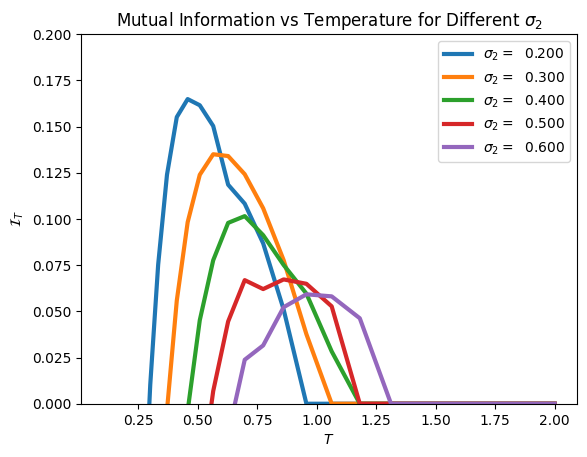

In [440]:
var_1, r, v = 0.25, 1, np.array([0,1])

for var_2 in [0.2, 0.3, 0.4, 0.5, 0.6]:
    
    data_1, _ = generate_data(var_1, var_2, r, v, num_samples=1000)
    data_2, _ = generate_data(var_1, var_2, r, v, num_samples=1000)

    DA = DeterministicAnnealing(T_max=2, T0=0.1, xi=0.9, tau=1e-8).fit(data_1, data_2)
    plt.plot(DA.Ts, DA.MIs, linewidth=3, label='$\sigma_2 =$ {:6.3f}'.format(var_2))
    plt.ylim(0,0.2)
    
plt.title('Mutual Information vs Temperature for Different $\sigma_2$')
plt.ylabel('$\mathcal{I}_T$')
plt.xlabel('$T$')
plt.legend()
plt.show()


<p style="background-color:#adebad;">
As before, also investigate the behavior of max MI vs. $\sigma_2$ for different $n,d$.
</p>

In [441]:
def max_MI_wrt_var(vars, r=1, v=np.array([0,1]), num_samples=1000, xi=0.9, T0=0.01):
    max_array = list()
    for var_2 in vars: 
        data_1, _ = generate_data(var_1, var_2, r, v, num_samples=num_samples)
        data_2, _ = generate_data(var_1, var_2, r, v, num_samples=num_samples)
        DA = DeterministicAnnealing(T0=T0, xi=xi).fit(data_1, data_2)
        max_array.append(np.max(DA.MIs))
    return vars, np.array(max_array)

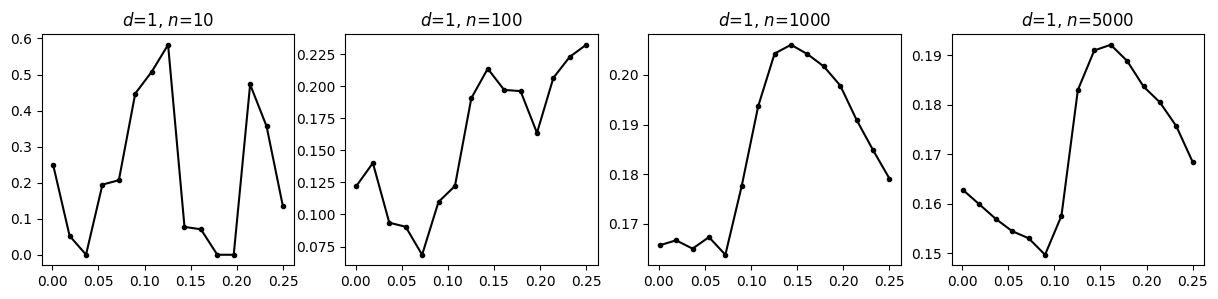

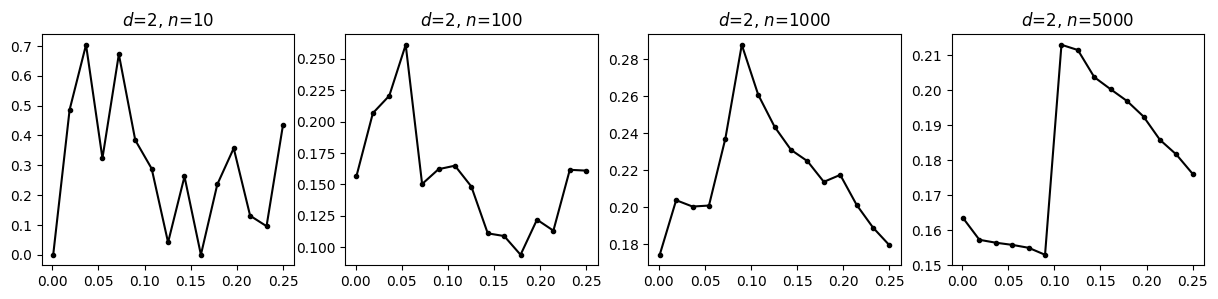

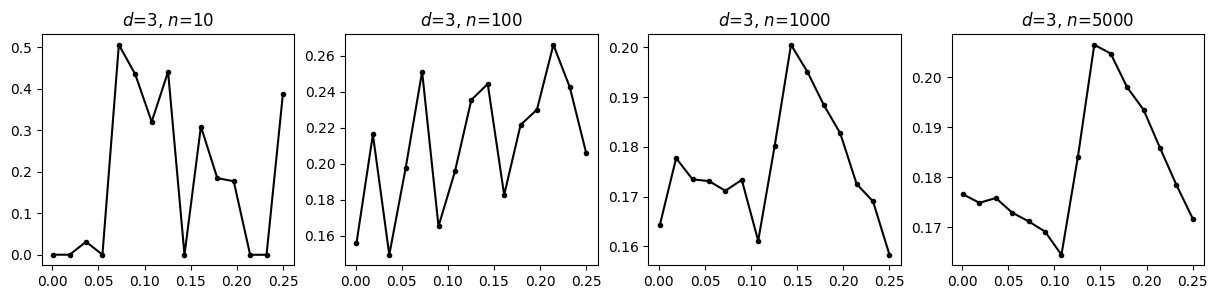

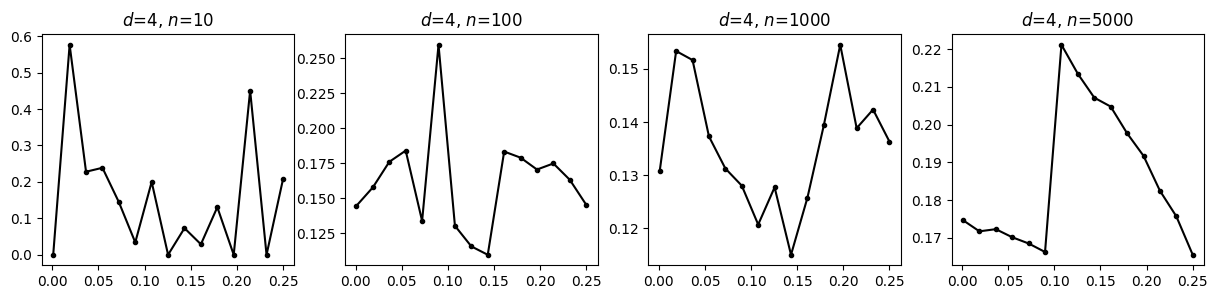

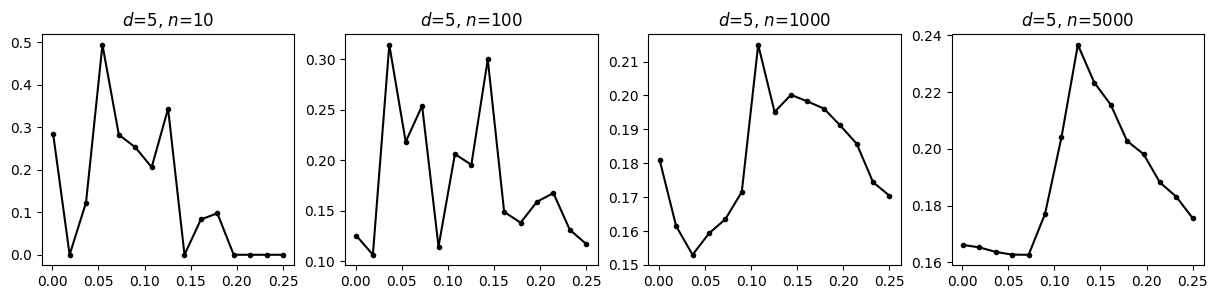

In [445]:
var_1 = 0.25
ds = np.arange(1, 6)
vs = [np.append(np.zeros(d-1), 1) for d in ds]
ns = [10, 100, 1000, 5000]

for v in vs:
    plt.figure(figsize=(15,3))
    for i, n in enumerate(ns):
        plt.subplot(1, len(ns), i+1)
        vars, max_MI = max_MI_wrt_var(vars=np.linspace(1e-3, 0.25, 15), v=v, num_samples=n, T0=0.1)
        plt.plot(vars, max_MI, marker='.', c='k')
        plt.title(f'$d$={v.shape[0]}, $n$={n}')
    plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>


Now we look at a slightly more complex problem, where a mean field approximation is need to carry out the calculation  of the partition functions. This is known as approximated sorting (See [2]). 
    <br>Write down the mean field equation  (7) and (8) in matrix form (note the typo in eq. 8 where the first sum should be extended only to $k-1$). Use the notation $A^{sum}_{ij} = \sum_{k=1}^j A_{ik}$, and implement these equations (you might want to use numpy.cumsum(, axis=1) to implement $A^{sum}$).

In [485]:
def compute_field(x,q):
    """x: pairwise comparison matrix
     q: probabilistic assignment matrix
     
     returns: the mean fields of MF approximations"""
     
    q = np.concatenate((np.zeros((q.shape[0], 1)), q, np.zeros((q.shape[0], 1))), axis=1)
    np.fill_diagonal(x, 0)
    field = x @ np.cumsum(q, axis=1)[:, :-2] + x.T @ np.cumsum(q[:,::-1], axis=1)[:,::-1][:,2:]
    
    
    return field - np.mean(field)
    

def assignment(beta, field, mu):
    """beta: inverse temperature
       field: mean fields
       mu: lagrange multipliers to enforce double stochasticity
     
     returns: probabilistic assignment matrix q"""    
    
    q = np.exp(-beta*(field + mu))
    q /= q.sum(axis=1)[:, np.newaxis]
    
    return q


The lagrange paramenters $\mu_k$ are such that the matrix $q$ obtained is doubly stochastic (it sums to one over both rows and columns). Using this property write down an iterative equation of the form $\mu = f(\beta, \mu, q)$ and implement it.


In [447]:
def iterative_mu(beta, q, mu):
    """beta: inverse temperature
        q: probabilistic assignment matrix
       mu: old lagrange multiplier
     
     returns: updated lagrange multiplier"""
     
    return mu + np.log(q.sum(axis=0))/beta

<p style="background-color:#adebad;">
Implement the mean field approximation for sorting filling out the provided class method. Note that for every iteration of the mean field, you have to run an entire cycle of iteration until convergence of $\mu$.
</p>

In [480]:
class MeanFieldSorting():
    
    def __init__(self, x, eps=1e-5):
        self.x = x
        self.eps = eps
        self.n = self.x.shape[0]
        
    def compute(self, beta):
        """beta: inverse temperature
     
         returns: q, field, mu"""
         
        np.random.seed(42)
        field, mu = np.zeros((self.n, self.n)), np.zeros(self.n)
        
        error_MF, tau = 1, 1e-4
        while error_MF > tau:
                
            field_old = field.copy()
            q = assignment(beta, field, mu)
            field = compute_field(self.x, q)
            
            error_q = 1
            while error_q > 1e-4:
                mu = iterative_mu(beta, q, mu)
                q = assignment(beta, field, mu)
                error_q = np.linalg.norm(q.sum(axis=0) - np.ones(q.sum(axis=0).shape))
                        
            
            error_MF = np.linalg.norm(field - field_old)
            
                
         
        return q, field, mu

<p style="background-color:#adebad;">
Implement a function for generating data like the one described in Section 2.1 and 2.5 of [2] to generate fig. 2, giving as output both the pairwise comparison matrix and the true order.
</p>

In [481]:
def generate_pairwise_data(n, noise):
    '''
    n: number of items to be sorted
    noise: standard deviation of the Normal noise to be added
    
    returns: X (pairwise comparisons), order (correct order of items) 
    '''
    
    order = np.random.RandomState(42).permutation(n)
    draw = order + np.random.normal(loc=0.0, scale=noise, size=n)
    
    return draw - draw[:,np.newaxis] > 0, order

In [482]:
x, order = generate_pairwise_data(10,0)
mf = MeanFieldSorting(x)
q, field, mu = mf.compute(1)
assert np.all(np.argmax(q, axis=1) == order)

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Implement the mutual information function in eq. 15
</p>

In [483]:
def mutual_information(x1, x2, beta):
    """x1,x2: two realization of the pairwise comparison matrix
        beta: inverse temperature
        
     returns: mutual information"""
    
    MF1 = MeanFieldSorting(x1)
    MF2 = MeanFieldSorting(x2)
    _, field_1, mu_1 = MF1.compute(beta)
    _, field_2, mu_2 = MF2.compute(beta)
    
    
    # use "log-sum-exp trick" for numerical robustness
    def log_sum_exp(x):
        c = np.max(x, axis=1, keepdims=True)
        return np.log(np.sum(np.exp(x - c), axis=1, keepdims=True)) + c
    
    x_1 = -beta*(field_1 + mu_1)
    x_2 = -beta*(field_2 + mu_2)
    x_12 = -beta*(field_1 + mu_1 + field_2 + mu_2)
        
    MI = 1 + np.sum(log_sum_exp(x_12) - log_sum_exp(x_1) - log_sum_exp(x_2)) / np.sum(np.log2(np.arange(1, x1.shape[0]+1)))
    
    return MI

<p style="background-color:#adebad;">
Show in a plot (Similar to the one in Figure 2a) the behaviour of the optimal $\beta$ as a function of the noise in the data distribution. Also show for some level of noises the mutual information as a function of beta.
</p>

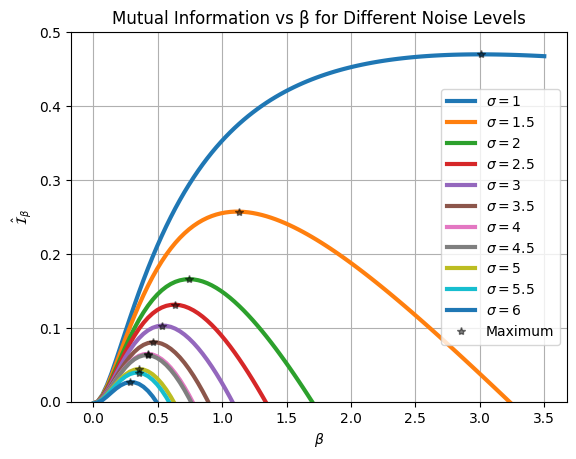

In [505]:
var, n, MIs, MI_max, beta_max = 1.5, 16, list(), list(), list()
vars = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]

data_1, _ = generate_pairwise_data(n, var)
data_2, _ = generate_pairwise_data(n, var)
betas = np.linspace(1e-3, 3.5, 100)

for var in vars:
    MIs = list()
    
    data_1, _ = generate_pairwise_data(n, var)
    data_2, _ = generate_pairwise_data(n, var)

    for beta in betas:
        MIs.append(mutual_information(data_1, data_2, beta))
        
    plt.plot(betas, MIs, label=f'$\sigma = ${var}', linewidth=3)
    idx = np.argmax(MIs)
    MI_max.append(MIs[idx])
    beta_max.append(betas[idx])
    
plt.plot(beta_max, MI_max, c='k', linestyle='', marker='*', alpha=0.5, label='Maximum')
plt.title('Mutual Information vs β for Different Noise Levels')
plt.ylabel('$\hat\mathcal{I}_β$')
plt.xlabel('$β$')
plt.ylim([0, 0.5])
plt.grid(True)

plt.legend()
plt.show()


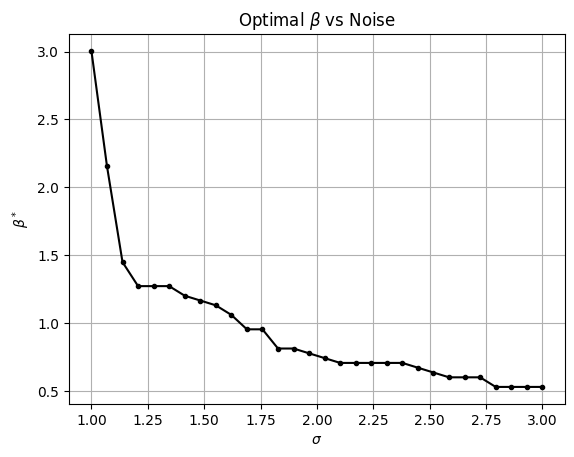

In [499]:
var, n, MIs, beta_max = 1.5, 16, list(), list()
vars = np.linspace(1, 3, 30)

data_1, _ = generate_pairwise_data(n, var)
data_2, _ = generate_pairwise_data(n, var)
betas = np.linspace(1e-6, 3.5, 100)

for var in vars:
    
    MIs = list()
    data_1, _ = generate_pairwise_data(n, var)
    data_2, _ = generate_pairwise_data(n, var)

    for beta in betas:
        MIs.append(mutual_information(data_1, data_2, beta))
        
    idx = np.argmax(MIs)
    beta_max.append(betas[idx])
    
plt.title('Optimal $β$ vs Noise')
plt.ylabel('$β^*$')
plt.xlabel('$\sigma$')
plt.grid(True)

plt.plot(vars, beta_max, marker='.', c='k')
plt.show()




## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.